# Brain-MDD Project
- Capstone Project

In [ ]:
import dotenv
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import mne
import enum

dotenv.load_dotenv()

class ChannelMapping(enum.Enum):
    Fp1 = 22
    Fp2 = 9
    F3 = 24
    F4 = 124
    C3 = 36
    C4 = 104
    P3 = 52
    P4 = 92
    O1 = 70
    O2 = 83
    F7 = 33
    F8 = 122
    T3 = 45
    T4 = 108
    T5 = 58
    T6 = 96

In [ ]:
# Get the path to the EEG data and report
EEG_DIR_PATH = os.getenv("EEG_DIR_PATH")
RAW_DIR_PATH = os.getenv("EEG_DIR_PATH") + "/raw"
SELECT_16_DIR_PATH = os.getenv("EEG_DIR_PATH") + "/16channels"
filteredDataPath = os.getenv("EEG_DIR_PATH") + "/filtered"
reportPath = os.getenv("EEG_REPORT_PATH")
EPOCHS_DIR_PATH = os.getenv("EEG_DIR_PATH") + "/epochs"

report = pd.read_excel(reportPath)
reportDf = pd.DataFrame(report)
reportDf["subject id"] = reportDf["subject id"].astype(str)
print(type(reportDf["subject id"][0]))

# Preprocessing
- Channel selection
- 5th-Order Butterworth bandpass filter
- ICA (next sprint)
- save as .fif file format + map with label
- do epoch

In [ ]:
# select the channels of interest; 16 channels
for file in os.listdir(RAW_DIR_PATH):
    if file.endswith(".npy"):
        data = np.load(RAW_DIR_PATH + "/" + file)
        selectedChannelsEeg = []
        for channel in ChannelMapping:
            selectedChannelsEeg.append(data[channel.value])
        selectedChannelsEeg = np.array(selectedChannelsEeg)
        print(selectedChannelsEeg.shape)
        np.save(EEG_DIR_PATH + "/16channels/" + file, selectedChannelsEeg)

In [ ]:
channelNames = [channel.name for channel in ChannelMapping]
channelTypes = ["eeg"] * len(channelNames)
sfreq = 250

# filtering and saving the data
for eeg16ChannelFile in os.listdir(SELECT_16_DIR_PATH):
    if eeg16ChannelFile.endswith(".npy"):
        data = np.load(SELECT_16_DIR_PATH + "/" + eeg16ChannelFile)
        info = mne.create_info(channelNames, sfreq, channelTypes)
        raw = mne.io.RawArray(data, info)
        
        montage = mne.channels.make_standard_montage("standard_1020")
        raw.set_montage(montage)
        
        raw.filter(0.5, 40) # Bandpass filter 0.5 - 40 Hz
        
        # ica = mne.preprocessing.ICA(n_components=16, random_state=97, max_iter=800)
        # ica.fit(raw)
        # raw = ica.apply(raw)
        
        eeg16ChannelFile = eeg16ChannelFile.split(".")[0]
        raw.save(EEG_DIR_PATH + "/filtered/" + eeg16ChannelFile + ".fif", overwrite=True)

In [ ]:
# map data with labels
mddDataLst = []
controlDataLst = []

# file name is matched with the "subject id" and label is "type"
for file in os.listdir(filteredDataPath):
    if file.endswith(".fif"):
        subjectId = file.split(".")[0]
        subjectId = subjectId[1:]
        subjectId = str(subjectId)
        result = reportDf[reportDf['subject id'] == subjectId]
        if result.empty:
            continue
        label = result["type"].values[0]
        if label == "MDD":
            mddDataLst.append(subjectId)
        elif label == "HC":
            controlDataLst.append(subjectId)
        os.rename(FILTERED_DIR_PATH + "/" + file, FILTERED_DIR_PATH + "/" + subjectId + "_" + label + ".fif")

In [ ]:
# do epoch
healthyControlEpochs = []
mddEpochs = []

# fs = 250, duration = 5s, samples = 250 * 5 = 1250
for file in os.listdir(FILTERED_DIR_PATH):
    if file.endswith(".fif"):
        raw = mne.io.read_raw_fif(FILTERED_DIR_PATH + "/" + file)
        subjectId = file.split("_")[0]
        label = file.split("_")[1].split(".")[0]
        if label == "MDD":
            mddEpochs.append(mne.make_fixed_length_epochs(raw, duration=5, preload=True))
        elif label == "HC":
            healthyControlEpochs.append(mne.make_fixed_length_epochs(raw, duration=5, preload=True))
            
# save the epochs
mddEpochs = mne.concatenate_epochs(mddEpochs)
healthyControlEpochs = mne.concatenate_epochs(healthyControlEpochs)
mddEpochs.save(EPOCHS_DIR_PATH + "/mdd-epo.fif")
healthyControlEpochs.save(EPOCHS_DIR_PATH + "/control-epo.fif")

## Feature Extraction

In [147]:
import dotenv
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from brainmdd.features.psd import EEGPowerSpectrum
import mne
import enum

dotenv.load_dotenv()

class ChannelMapping(enum.Enum):
    Fp1 = 22
    Fp2 = 9
    F3 = 24
    F4 = 124
    C3 = 36
    C4 = 104
    P3 = 52
    P4 = 92
    O1 = 70
    O2 = 83
    F7 = 33
    F8 = 122
    T3 = 45
    T4 = 108
    T5 = 58
    T6 = 96

# Declare Global Variables
NUM_CHANNELS = 16
MODMA_SFREQ = 250
EEG_DIR_PATH = os.getenv("EEG_DIR_PATH")
RAW_DIR_PATH = os.getenv("EEG_DIR_PATH") + "/raw"
SELECT_16_DIR_PATH = os.getenv("EEG_DIR_PATH") + "/16channels"
FILTERED_DIR_PATH = os.getenv("EEG_DIR_PATH") + "/filtered"
EPOCHS_DIR_PATH = os.getenv("EEG_DIR_PATH") + "/epochs"

# Declare Feature Dictionary
featureDict = {
    "norm_power": {
        "mdd": {
            "delta": [],
            "theta": [],
            "alpha": [],
            "beta": [],
            "gamma": []
            },
        "control": {
            "delta": [],
            "theta": [],
            "alpha": [],
            "beta": [],
            "gamma": []
            }
        }
    }    

In [2]:
# Load the epochs
mddEpochs = mne.read_epochs(EPOCHS_DIR_PATH + "/mdd-epo.fif")
controlEpochs = mne.read_epochs(EPOCHS_DIR_PATH + "/control-epo.fif")
mddEpochs = mddEpochs.get_data()
controlEpochs = controlEpochs.get_data()

Reading /Users/wachiii/Workschii/brain-mdd/data/epochs/mdd-epo.fif ...
    Found the data of interest:
        t =       0.00 ...    4996.00 ms
        0 CTF compensation matrices available
Not setting metadata
1328 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/wachiii/Workschii/brain-mdd/data/epochs/control-epo.fif ...
    Found the data of interest:
        t =       0.00 ...    4996.00 ms
        0 CTF compensation matrices available
Not setting metadata
1753 matching events found
No baseline correction applied
0 projection items activated


In [3]:
psdObjMdd = EEGPowerSpectrum(mddEpochs, 250, ifNormalize=True)
mddPsdFeatures = psdObjMdd.run()
psdObjCtrl = EEGPowerSpectrum(controlEpochs, 250, ifNormalize=True)
controlPsdFeatures = psdObjCtrl.run()
print(mddPsdFeatures.shape)
print(controlPsdFeatures.shape)

(1328, 5, 16)
(1753, 5, 16)


In [4]:
for epoch in mddPsdFeatures:
    bandCounter = 0
    for band in epoch:
        if bandCounter == 0:
            featureDict["norm_power"]["mdd"]["delta"].append(band)
        elif bandCounter == 1:
            featureDict["norm_power"]["mdd"]["theta"].append(band)
        elif bandCounter == 2:
            featureDict["norm_power"]["mdd"]["alpha"].append(band)
        elif bandCounter == 3:
            featureDict["norm_power"]["mdd"]["beta"].append(band)
        elif bandCounter == 4:
            featureDict["norm_power"]["mdd"]["gamma"].append(band)
        bandCounter += 1

for epoch in controlPsdFeatures:
    bandCounter = 0
    for band in epoch:
        if bandCounter == 0:
            featureDict["norm_power"]["control"]["delta"].append(band)
        elif bandCounter == 1:
            featureDict["norm_power"]["control"]["theta"].append(band)
        elif bandCounter == 2:
            featureDict["norm_power"]["control"]["alpha"].append(band)
        elif bandCounter == 3:
            featureDict["norm_power"]["control"]["beta"].append(band)
        elif bandCounter == 4:
            featureDict["norm_power"]["control"]["gamma"].append(band)
        bandCounter += 1                                                           

In [ ]:
# check the shape of the features
print(type(featureDict["norm_power"]["mdd"]["delta"]))
print(len(featureDict["norm_power"]["mdd"]["delta"]))
print(type(featureDict["norm_power"]["mdd"]["delta"][0]))
print((featureDict["norm_power"]["mdd"]["delta"][0].shape))
print(featureDict["norm_power"]["mdd"]["delta"][0])

print("------------------")

print(type(featureDict["norm_power"]["control"]["delta"]))
print(len(featureDict["norm_power"]["control"]["delta"]))
print(type(featureDict["norm_power"]["control"]["delta"][0]))
print((featureDict["norm_power"]["control"]["delta"][0].shape))
temp = featureDict["norm_power"]["control"]["delta"]
temp = np.array(temp)
print(temp.shape)
print(featureDict["norm_power"]["control"]["delta"][0])

# Permutation test and False Discovery Rate Correction
" Topological maps of p-values from this method can help visualize the spatial distribution of significant effects across channels. "

### STEP 1: Perform the permutation test on the feature values for each channel -> p-value for each channel
" Shuffle the data many times (e.g., 10,000 times) and calculate the test statistic for each shuffle to create a null distribution."
- **Compute the Observed Test Statistic**
    - Calculate the difference between the means (or medians) of the two groups in the original data. This is your observed test statistic.
- **Combine and Shuffle the Data** 
    - Pool the data from both groups into one dataset.
    - Randomly shuffle (permute) the data.
    - Split the shuffled data into two groups of the same size as the original groups.
- **Recalculate the Test Statistic**
    - Compute the test statistic for the permuted groups (e.g., mean difference).
- **Repeat Many Times**
    - Repeat the shuffle and recalculation process many times (e.g., 10,000 permutations) to build a null distribution of test statistics.
- **Calculate the p-value**
    - Compare the observed test statistic to the null distribution.
- **RESULT: p-value** 
    - (If the p-value is small (e.g., < 0.05 < 0.05), reject the null hypothesis (h0 = no difference))

### STEP 2: Apply FDR Correction to control the FDR
- use Benjamini-Hochberg procedure.
- RESULT: corrected p-value 

### STEP 3: Visualizing FDR-Corrected Results on a topographical brain map

In [129]:
import numpy as np
from statsmodels.stats.multitest import fdrcorrection

NUM_PERMUTATIONS = 50000
NUM_CHANNELS = 16

mddBands shape: (1328, 16)
controlBands shape: (1753, 16)
pValues: [0.12848 0.      0.5435  0.      0.22798 0.      0.1445  0.      0.59344
 0.15968 0.14392 0.      0.44932 0.      0.09864 0.     ]
pValues shape: (16,)


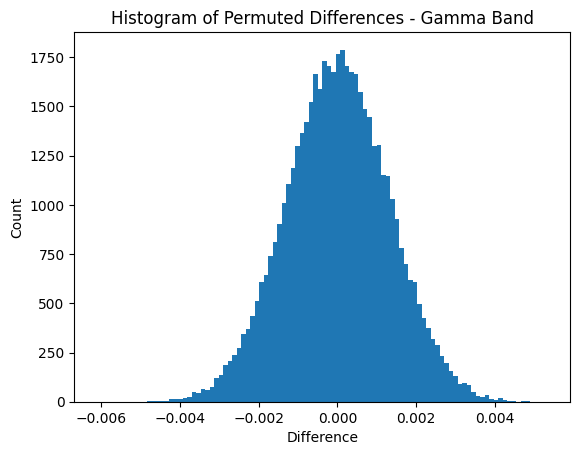

In [ ]:
mddBands = np.array(featureDict["norm_power"]["mdd"]["gamma"])
controlBands = np.array(featureDict["norm_power"]["control"]["gamma"])
# print(f"mddBands shape: {mddBands.shape}")
# print(f"controlBands shape: {controlBands.shape}")

pValues = []

for channel in range(NUM_CHANNELS):
    observedDiff = np.mean(mddBands[:, channel]) - np.mean(controlBands[:, channel])
    poolData = np.hstack((mddBands[:, channel], controlBands[:, channel]))
    permDiff = []
    
    for _ in range(NUM_PERMUTATIONS):
        np.random.shuffle(poolData)
        permControl = poolData[:len(mddBands)]
        permMdd = poolData[len(mddBands):]
        permDiff.append(np.mean(permMdd) - np.mean(permControl))
        
    permDiff = np.array(permDiff)
    pValue = np.sum(np.abs(permDiff) >= np.abs(observedDiff)) / len(permDiff)
    pValues.append(pValue)

pValues = np.array(pValues)
# print(f"pValues: {pValues}")
# print(f"pValues shape: {pValues.shape}")

# plot the histogram of permuted differences
# plt.hist(permDiff, bins=100)
# plt.xlabel('Difference')
# plt.ylabel('Count')
# plt.title('Histogram of Permuted Differences - Gamma Band')
# plt.show()

In [ ]:
# mddBands = np.array(featureDict["norm_power"]["mdd"]["gamma"])
# controlBands = np.array(featureDict["norm_power"]["control"]["gamma"])

# pValues = []

# for channel in range(NUM_CHANNELS):
#     observedDiff = np.mean(controlBands[:, channel]) - np.mean(mddBands[:, channel])
#     poolData = np.hstack((controlBands[:, channel], mddBands[:, channel]))
#     permDiff = []
    
#     for _ in range(NUM_PERMUTATIONS):
#         np.random.shuffle(poolData)
#         permControl = poolData[:len(controlBands)]
#         permMdd = poolData[len(controlBands):]
#         permDiff.append(np.mean(permControl) - np.mean(permMdd))
        
# #     permDiff = np.array(permDiff)
# #     pValue = np.mean(np.abs(permDiff) >= np.abs(observedDiff))
# #     pValues.append(pValue)
    
# # pValues = np.array(pValues)

# # plot the histogram of permuted differences
# plt.hist(permDiff, bins=100)
# plt.show()

### STEP 2: Apply FDR Correction to control the FDR
- use Benjamini-Hochberg procedure.
- RESULT: corrected p-value 


In [146]:
aplha = 0.05
# numTests = len(pValues)
# sortedPValues = np.sort(pValues)
# bhCriticalValue = (np.array(range(1, numTests + 1)) / numTests) * aplha

# fdrSignificant = sortedPValues <= bhCriticalValue   # Compare the sorted p-values to the critical value

# fdrSignificantReordered = np.zeros_like(fdrSignificant)
# fdrSignificantReordered[np.argsort(pValues)] = fdrSignificant

# print(fdrSignificantReordered)

fdrSignificant, fdrCorrectedPValue = fdrcorrection(pValues, alpha=aplha)
print(fdrCorrectedPValue)
print(fdrCorrectedPValue.shape)
print(fdrSignificant)

[0.21018182 0.         0.57973333 0.         0.28059077 0.
 0.21018182 0.         0.59344    0.21290667 0.21018182 0.
 0.51350857 0.         0.19728    0.        ]
(16,)
[False  True False  True False  True False  True False False False  True
 False  True False  True]


### STEP 3: Visualizing FDR-Corrected Results on a topographical brain map

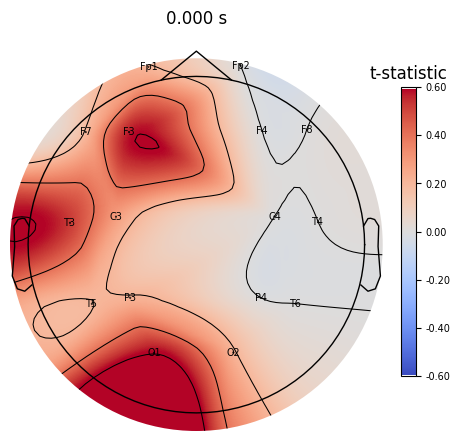

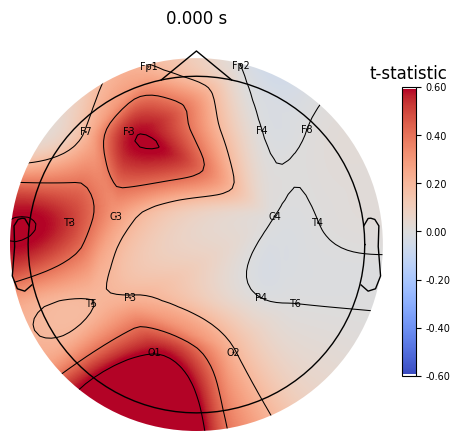

In [152]:
channelNames = [channel.name for channel in ChannelMapping]
channelTypes = ["eeg"] * len(channelNames)
montage = mne.channels.make_standard_montage("standard_1020")
info = mne.create_info(channelNames, MODMA_SFREQ, channelTypes)
info.set_montage(montage)

fdrCorrectedPValue = fdrCorrectedPValue.reshape((16, 1))
evoked = mne.EvokedArray(fdrCorrectedPValue, info)
evoked.plot_topomap(times=0, scalings=1, time_unit='s', size=3, cmap='coolwarm', show_names=True, cbar_fmt="%0.2f", units="t-statistic")

(1328, 16)


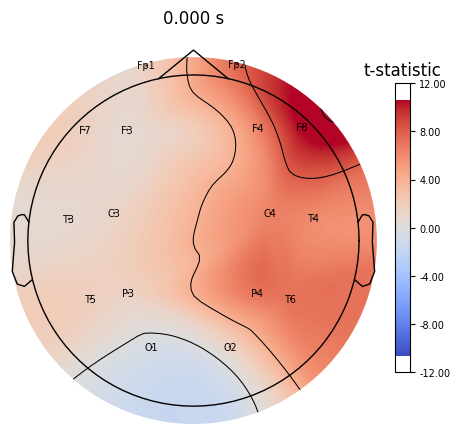

TypeError: only length-1 arrays can be converted to Python scalars

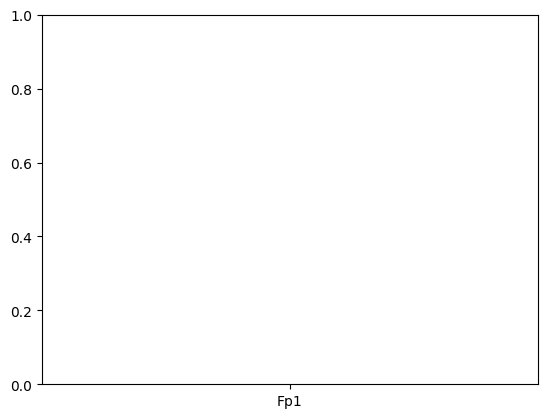

In [105]:
# For delta band
mddDeltaBands = np.array(featureDict["norm_power"]["mdd"]["gamma"])
controlDeltaBands = np.array(featureDict["norm_power"]["control"]["gamma"])
studentTTestDelta = np.zeros(mddDeltaBands.shape[1])
print(mddDeltaBands.shape)

for channel in range(NUM_CHANNELS):
    tStats, pVal = ttest_ind(mddDeltaBands[:, channel], controlDeltaBands[:, channel])
    studentTTestDelta[channel] = tStats
studentTTestDelta = studentTTestDelta.reshape((16, 1))

channelNames = [channel.name for channel in ChannelMapping]
channelTypes = ["eeg"] * len(channelNames)
montage = mne.channels.make_standard_montage("standard_1020")
info = mne.create_info(channelNames, MODMA_SFREQ, channelTypes)
info.set_montage(montage)
evoked = mne.EvokedArray(studentTTestDelta, info)
evoked.plot_topomap(times=0, scalings=1, size=3, cmap="coolwarm", show_names=True, cbar_fmt="%0.2f", units="t-statistic")
# plot bar graph
plt.bar(channelNames, studentTTestDelta)
plt.xlabel("Channels")
plt.ylabel("T-Statistic")
plt.title("T-Statistic for Delta Band")
plt.show()


## Classification

Random State:  10604
Accuracy:  0.6531440162271805
Sensitivity:  0.5441458733205374


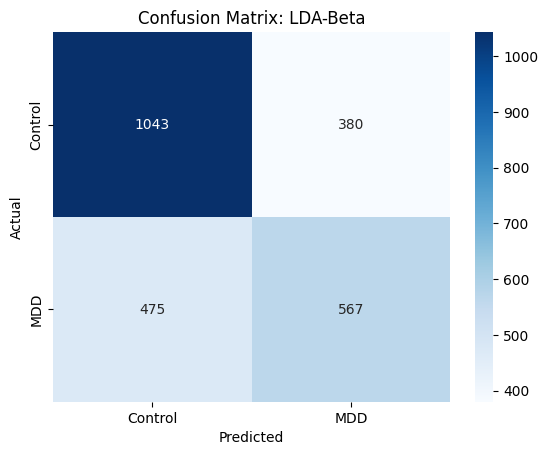

         f1  precision  sensitivity  specificity  accuracy
0  0.570136   0.598733     0.544146     0.732959  0.653144


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Example data with 16 features
deltaMdd = featureDict["norm_power"]["mdd"]["beta"]
deltaControl = featureDict["norm_power"]["control"]["beta"]
deltaMdd = np.array(deltaMdd)
deltaControl = np.array(deltaControl)

# Concatenate the data
X = np.concatenate((deltaMdd, deltaControl), axis=0)
y = np.concatenate((np.ones(len(deltaMdd)), np.zeros(len(deltaControl))), axis=0)

# Reduce to 2D using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Train-test split
for randomState in range(1, 15000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.80, random_state=randomState, shuffle=True)
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    if lda.score(X_test, y_test) > 0.65:
        y_pred = lda.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sensitivity = recall_score(y_test, y_pred)
        if sensitivity > 0.52:
            print("Random State: ", randomState)
            print("Accuracy: ", lda.score(X_test, y_test))
            print("Sensitivity: ", sensitivity)
            break

# # Create a mesh grid
# x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
# y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
# xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# # Predict on the grid
# Z = lda.predict(np.c_[xx.ravel(), yy.ravel()])
# Z = Z.reshape(xx.shape)

# # Plot the decision boundary
# plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
# plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', marker='o', label='Train')
# plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors='k', marker='x', label='Test')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('LDA Decision Boundary')
# plt.legend()
# plt.show()

# Confusion matrix
y_pred = lda.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xticks([0.5, 1.5], ['Control', 'MDD'])
plt.yticks([0.5, 1.5], ['Control', 'MDD'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: LDA-Beta')
plt.show()

# Calculate metrics
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred)
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])


# Show metrics as a dataframe
df = pd.DataFrame({
    "f1": [f1],
    "precision": [precision],
    "sensitivity": [sensitivity],
    "specificity": [specificity],
    "accuracy": [accuracy]
})
print(df)

Random State:  1634
Accuracy:  0.7200811359026369
Sensitivity:  0.640074211502783


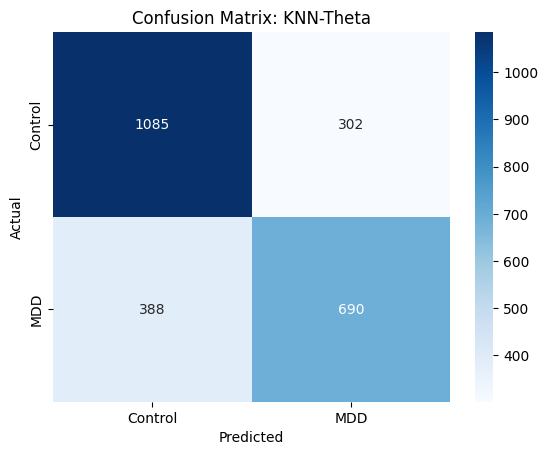

In [103]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Train-test split

thetaMdd = featureDict["norm_power"]["mdd"]["theta"]
thetaControl = featureDict["norm_power"]["control"]["theta"]
thetaMdd = np.array(thetaMdd)
thetaControl = np.array(thetaControl)

# Concatenate the data
X = np.concatenate((thetaMdd, thetaControl), axis=0)
y = np.concatenate((np.ones(len(thetaMdd)), np.zeros(len(thetaControl))), axis=0)

for randomState in range(1, 15000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.80, random_state=randomState, shuffle=True)
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)
    if knn.score(X_test, y_test) > 0.72:
        y_pred = knn.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sensitivity = recall_score(y_test, y_pred)
        if sensitivity > 0.52:
            print("Random State: ", randomState)
            print("Accuracy: ", knn.score(X_test, y_test))
            print("Sensitivity: ", sensitivity  )
            break
        
# Confusion matrix
y_pred = knn.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xticks([0.5, 1.5], ['Control', 'MDD'])
plt.yticks([0.5, 1.5], ['Control', 'MDD'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: KNN-Theta')
plt.show()
